# Single Location

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
from datetime import datetime
from dataclasses import dataclass
from typing import Callable, List

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.losses import BinaryCrossentropy, BinaryFocalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

2024-11-06 14:47:40.772211: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-06 14:47:40.930071: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [55]:
from models.handnet_based_model import handnet_based_model
from util.training import init_device
from util.training.dataloader import split_data_for_single_location
from util.training.losses import IoULoss
from util.training.metrics import IntersectionOverUnion, MeanPixelAccuracy
from util.plot import plot_predictions

In [4]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.11.0


# 準備
---

## デバイスの初期化

In [8]:
!nvidia-smi

Wed Nov  6 14:47:57 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 470.74       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:18:00.0 Off |                  Off |
| 42%   68C    P2   151W / 300W |  14954MiB / 48682MiB |     36%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A6000    On   | 00000000:3B:00.0 Off |                  Off |
| 48%   

In [9]:
# 使用するGPUを指定
gpu = [2]

In [10]:
seed = 42
init_device(seed, gpu)

Setting random seed: 42
Random seed set for Python, NumPy, and TensorFlow.
Detected 5 GPU(s): ['/physical_device:GPU:0', '/physical_device:GPU:1', '/physical_device:GPU:2', '/physical_device:GPU:3', '/physical_device:GPU:4']
Visible GPU devices (1): ['/physical_device:GPU:2']


## ハイパーパラメータクラスの定義

In [11]:
@dataclass
class HyperParameters:
    epochs: int
    batch_size: int
    loss_function: Callable
    metrics: List[Callable]
    optimizer: Callable

## モデルの初期化関数の定義

In [12]:
def init_model(hparam):
    model = handnet_based_model(
        input_shape = (10, 52, 2),
        num_block1 = 3,
        num_block2 = 3,
        num_residual_blocks = 14, # 残差ブロックは増やすと重くなる
    )
    
    model.compile(
        optimizer = hparam.optimizer,
        loss = hparam.loss_function,
        metrics = hparam.metrics,
    )

    return model

## コールバック準備関数の定義

In [13]:
def prepare_callbacks(hparam, log_dirpath):

    callbacks = [
        TensorBoard(log_dir=log_dirpath, histogram_freq=1),
        EarlyStopping(
            monitor='val_iou',
            mode='max',
            patience=10,
            restore_best_weights=True,
        )
    ]

    return callbacks

## モデルを訓練する関数の定義

In [14]:
def train(hparam, dataset, log_dirpath):
    print(f'log_dir = {log_dirpath}')

    # データの用意
    train_data, valid_data, test_data = dataset
    X_train, Y_train = train_data
    X_valid, Y_valid = valid_data
    X_test, Y_test = test_data

    # モデルを作成
    model = init_model(hparam)

    # モデルのフィッティング
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_valid, Y_valid),
        epochs = hparam.epochs,
        batch_size = hparam.batch_size,
        verbose = 1,
        callbacks = prepare_callbacks(hparam, log_dirpath)
    )

    # テストデータでの評価
    test_loss, *test_metric = model.evaluate(X_test, Y_test, verbose=2)
    print(f"Test Loss: {test_loss}, Test Metric: {test_metric}")

    return history, model

# モデルの訓練
---

In [15]:
def get_log_dirpath(root_log_dirpath, notebook_name):
    date = datetime.now().strftime("%Y-%m-%d")
    time = datetime.now().strftime("%H-%M-%S")
    log_dirpath = os.path.join(
        root_log_dirpath, 
        date,
        notebook_name,
        time
    )

    return log_dirpath

In [90]:
# データをロード
csi_preprocess_id = 'amp_and_phase_mean_norm'
location = '511'
dataset = split_data_for_single_location(csi_preprocess_id, location, shuffle=True)

# ハイパーパラメータの指定
hparam = HyperParameters(
    epochs = 150,
    batch_size = 256,
    optimizer = Adam(learning_rate=0.001),
    loss_function = BinaryFocalCrossentropy(gamma=2), # BinaryCrossentropy()
    metrics = [IntersectionOverUnion(threshold=0.5), MeanPixelAccuracy()],
)

# ログディレクトリを指定
project_dirpath = Path('/tf/workspace/deformation-prediction-multi-environment')
root_log_dirpath = project_dirpath/'logs' 
notebook_name = f'tsingle_location_real_and_imag_{location}'
log_dirpath = get_log_dirpath(root_log_dirpath, notebook_name)

history, model = train(hparam, dataset, log_dirpath)

train data shuffled.
log_dir = /tf/workspace/deformation-prediction-multi-environment/logs/2024-11-06/tsingle_location_real_and_imag_511/17-14-06
Epoch 1/150
33/33 [==============================] - 57s 255ms/step - loss: 0.1206 - iou: 0.1192 - mpa: 0.5497 - val_loss: 0.1399 - val_iou: 0.1660 - val_mpa: 0.5794
Epoch 2/150
33/33 [==============================] - 7s 210ms/step - loss: 0.0834 - iou: 0.3727 - mpa: 0.6907 - val_loss: 0.1188 - val_iou: 0.1958 - val_mpa: 0.5957
Epoch 3/150
33/33 [==============================] - 7s 202ms/step - loss: 0.0758 - iou: 0.4596 - mpa: 0.7383 - val_loss: 0.1119 - val_iou: 0.1920 - val_mpa: 0.5936
Epoch 4/150
33/33 [==============================] - 7s 206ms/step - loss: 0.0690 - iou: 0.5286 - mpa: 0.7750 - val_loss: 0.1063 - val_iou: 0.1660 - val_mpa: 0.5809
Epoch 5/150
33/33 [==============================] - 7s 214ms/step - loss: 0.0656 - iou: 0.5532 - mpa: 0.7866 - val_loss: 0.0989 - val_iou: 0.2445 - val_mpa: 0.6200
Epoch 6/150
33/33 [=========

# 評価
---

In [91]:
_, valid_data, test_data = dataset
X_valid, y_valid = valid_data
X_test, y_test = test_data

## 各メトリックの平均値

In [92]:
results = model.evaluate(X_test, y_test)
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.04f}")

57/57 [==============================] - 2s 28ms/step - loss: 0.1622 - iou: 0.3147 - mpa: 0.6500
loss: 0.1622
iou: 0.3147
mpa: 0.6500


# 予測結果のサンプルをランダムに表示

In [93]:
metrics = {'IoU': IntersectionOverUnion(threshold=0.5), 'mPA': MeanPixelAccuracy()}

57/57 [==============================] - 1s 24ms/step


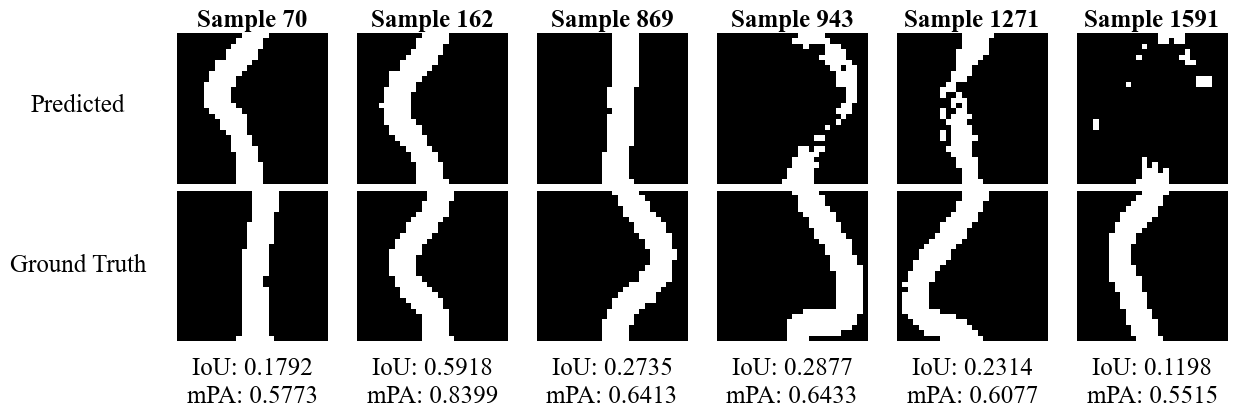

In [103]:
# 検証セット
plot_predictions(model, X_valid, y_valid, n_samples=6, threshold=0.5, seed=42, metrics=metrics)

57/57 [==============================] - 1s 23ms/step


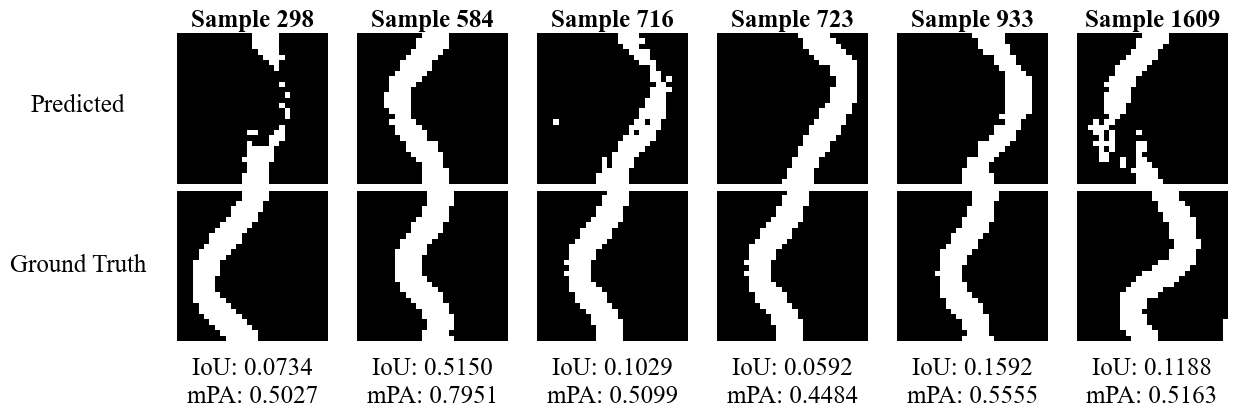

In [102]:
# テストセット
plot_predictions(model, X_test, y_test, n_samples=6, threshold=0.5, seed=46, metrics=metrics)

In [96]:
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(np.float32)

57/57 [==============================] - 1s 23ms/step


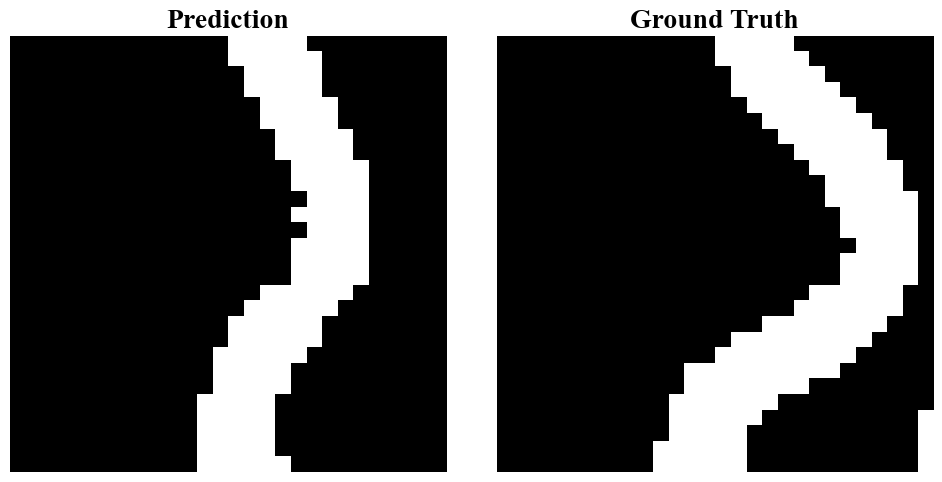

In [97]:
# インデックスと予測を設定
i = 1700

# 1行2列のサブプロットを作成
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 2つの画像を取得
pred_image = y_pred[i]
true_image = y_test[i]

# 左側に予測結果を表示
axes[0].imshow(pred_image, cmap='gray')
axes[0].axis('off')
axes[0].set_title("Prediction")

# 右側に正解ラベルを表示
axes[1].imshow(true_image, cmap='gray')
axes[1].axis('off')
axes[1].set_title("Ground Truth")

# レイアウト調整
plt.tight_layout()
plt.show()

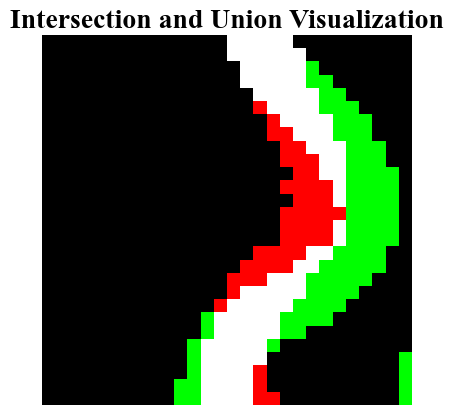

In [98]:
# IntersectionとUnionを計算
intersection = np.logical_and(pred_image, true_image)  # 共通部分
union = np.logical_or(pred_image, true_image)          # 結合部分

# RGBイメージを作成
visualization = np.zeros((pred_image.shape[0], pred_image.shape[1], 3), dtype=np.float32)

# 赤: 予測 (y_pred)、緑: 正解 (y_test)、白: 共通部分
visualization[..., 0] = pred_image  # 赤チャンネルに予測を割り当て
visualization[..., 1] = true_image  # 緑チャンネルに正解を割り当て
visualization[..., 2] = intersection  # 青に共通部分

# 表示
plt.imshow(visualization)
plt.axis('off')
plt.title("Intersection and Union Visualization")
plt.show()